In [24]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## 1-Data Exploration

In [25]:
# Load dữ liệu
df = pd.read_csv("train.csv")
df.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [26]:
# thông tin về dòng và cột 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [27]:
# Kiểm tra giá trị bị null
Missing_values = df.isnull().sum()
Missing_values

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [28]:
#chuyển đổi định dạng thành datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

In [29]:
#in ra dòng đầu và dòng cuối của cột ngày tháng
print(f"First order recorded in: {df['Order Date'].min()}")
print(f"Last order recorded in: {df['Order Date'].max()}")

First order recorded in: 2015-01-03 00:00:00
Last order recorded in: 2018-12-30 00:00:00


## 2-Data Cleaning

In [30]:
#Tạo một DataFrame mới 
df_filtered = df[['Order ID',  'Order Date', 'Sales', 'Customer ID']].copy()

In [31]:
#Tổng số giá trị thiếu (NaN) trong mỗi cột
df_filtered.isnull().sum()

Order ID       0
Order Date     0
Sales          0
Customer ID    0
dtype: int64

In [32]:
#Làm tròn giá trị trong cột về số nguyên gân nhất và chuyển sang string
df_filtered['Customer ID'] = df_filtered['Customer ID'].round(0).astype('str')

In [33]:
#hiển thị kiểu dữ liệu
df_filtered.dtypes

Order ID               object
Order Date     datetime64[ns]
Sales                 float64
Customer ID            object
dtype: object

## 3-Feature Engineering

##### Recency: Khoảng cách ngày mua hàng gần đây nhất 
##### Frequency: Tần suất mua hàng
##### Monetary: Tổng số tiền mà khách hàng đã mua hàng

In [34]:
#tính toán các chỉ số RFM (Recency, Frequency, Monetary) cho mỗi khách hàng từ dữ liệu đơn hàng
from datetime import datetime

date_snapshot =  df_filtered['Order Date'].max() + pd.Timedelta(days=1)

customers = df_filtered.groupby('Customer ID').agg({'Order Date':lambda x: (date_snapshot - x.max()).days,
                                                   'Order ID':'nunique',
                                                   'Sales':'sum'}).rename(columns={'Order Date':'Recency',
                                                                                         'Order ID': 'Frequency',
                                                                                         'Sales': 'Monetary'})

In [35]:
print(customers.head())
print('=============================================')
print(customers.describe())

             Recency  Frequency  Monetary
Customer ID                              
AA-10315         185          5  5563.560
AA-10375          20          9  1056.390
AA-10480         260          4  1790.512
AA-10645          56          6  5086.935
AB-10015         416          3   886.156
           Recency   Frequency      Monetary
count   793.000000  793.000000    793.000000
mean    149.286255    6.206810   2851.874884
std     187.081466    2.525647   2620.668723
min       1.000000    1.000000      4.833000
25%      31.000000    4.000000   1081.466000
50%      76.000000    6.000000   2215.002000
75%     185.000000    8.000000   3670.258000
max    1166.000000   17.000000  25043.050000


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

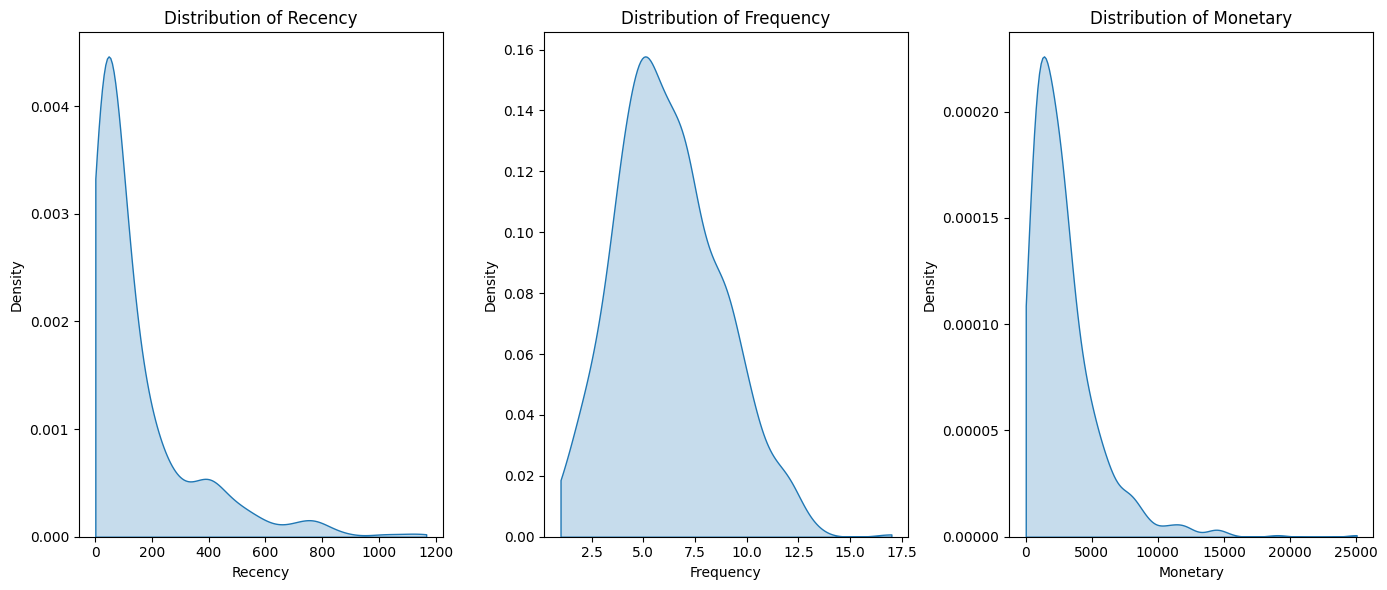

In [37]:
#Hiển thị biểu đồ gồm 3 đường phân phối (KDE plots) cho các đặc trưng mới được tạo ra từ dữ liệu RFM
fig, axes = plt.subplots(1,3, figsize=(14,6))

sns.kdeplot(data=customers, x='Recency', ax=axes[0], fill=True, cut=0)
axes[0].set_title('Distribution of Recency')

sns.kdeplot(data=customers, x='Frequency', ax=axes[1], fill=True, cut=0)
axes[1].set_title('Distribution of Frequency')

sns.kdeplot(data=customers, x='Monetary', ax=axes[2], fill=True, cut=0)
axes[2].set_title('Distribution of Monetary')

plt.tight_layout()

## 4-Data Preprocessing

In [38]:

from sklearn.preprocessing import PowerTransformer

In [39]:
#Sử dụng phương pháp Box-Cox để biến đổi các đặc trưng có phân phối lệch
pt = PowerTransformer(method='box-cox')
customers_transformed = pt.fit_transform(customers)

In [40]:
# tạo một df mới lưu trữ dữ liệu đã bị biến dổi 
customers_transformed_df = pd.DataFrame(customers_transformed, index=customers.index, columns=customers.columns)

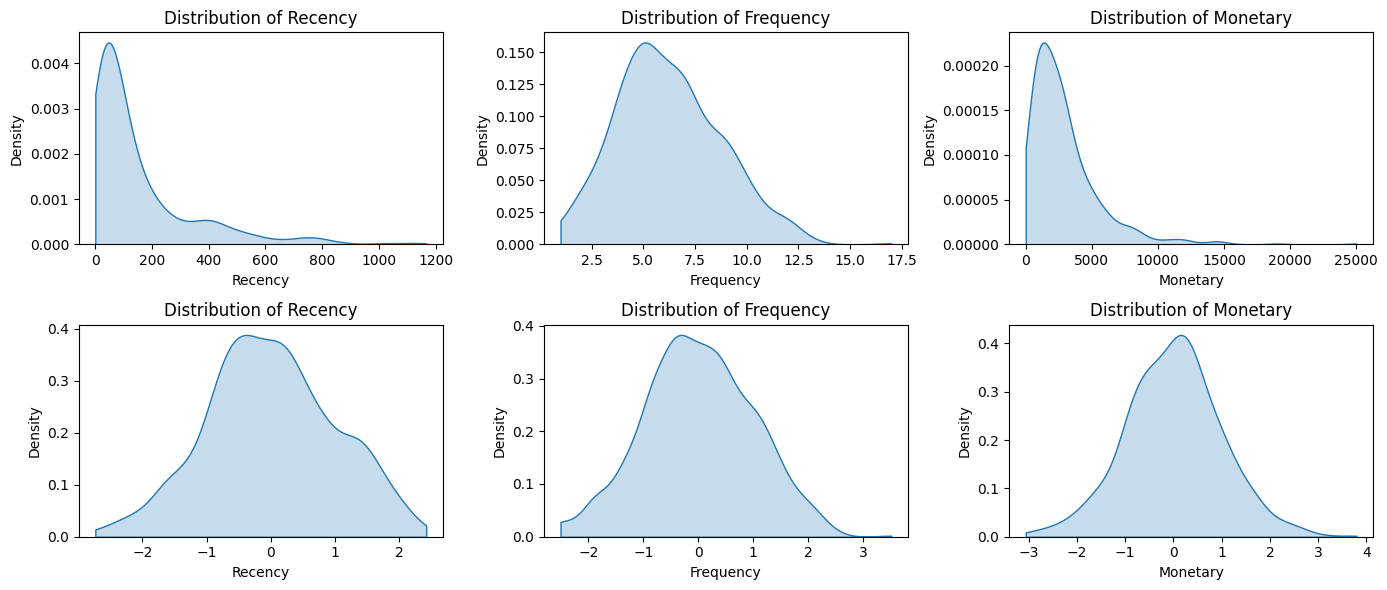

In [41]:
#Hiển thị phân phối của các thuộc tính Recency, Frequency và Monetary trước và sau khi được biến đổi. 
fig, axes = plt.subplots(2,3, figsize=(14,6))

sns.kdeplot(data=customers, x='Recency', ax=axes[0,0], fill=True, cut=0)
axes[0,0].set_title('Distribution of Recency')
sns.kdeplot(data=customers, x='Frequency', ax=axes[0,1], fill=True, cut=0)
axes[0,1].set_title('Distribution of Frequency')
sns.kdeplot(data=customers, x='Monetary', ax=axes[0,2], fill=True, cut=0)
axes[0,2].set_title('Distribution of Monetary')

sns.kdeplot(data=customers_transformed_df, x='Recency', ax=axes[1,0], fill=True, cut=0)
axes[1,0].set_title('Distribution of Recency')
sns.kdeplot(data=customers_transformed_df, x='Frequency', ax=axes[1,1], fill=True, cut=0)
axes[1,1].set_title('Distribution of Frequency')
sns.kdeplot(data=customers_transformed_df, x='Monetary', ax=axes[1,2], fill=True, cut=0)
axes[1,2].set_title('Distribution of Monetary')

plt.tight_layout()

In [42]:
# Xử lý ngoại lai và xóa các dòng chứa giá trị ngoại lai
Q1 = customers['Recency'].quantile(0.1)
Q3 = customers['Recency'].quantile(0.9)
IQR = Q3 - Q1
recency_outliers = customers[(customers['Recency'] < Q1 - 1.5*IQR) | (customers['Recency'] > Q3 + 1.5*IQR)].index
print(f"Số lượng giá trị ngoại lai trong cột Recency: {len(recency_outliers)}")

Q1 = customers['Frequency'].quantile(0.1)
Q3 = customers['Frequency'].quantile(0.9)
IQR = Q3 - Q1
frequency_outliers = customers[(customers['Frequency'] < Q1 - 1.5*IQR) | (customers['Frequency'] > Q3 + 1.5*IQR)].index
print(f"Số lượng giá trị ngoại lai trong cột Frequency: {len(frequency_outliers)}")

Q1 = customers['Monetary'].quantile(0.1)
Q3 = customers['Monetary'].quantile(0.9)
IQR = Q3 - Q1
monetary_outliers = customers[(customers['Monetary'] < Q1 - 1.5*IQR) | (customers['Monetary'] > Q3 + 1.5*IQR)].index
print(f"Số lượng giá trị ngoại lai trong cột Monetary: {len(monetary_outliers)}")

# Kết hợp các chỉ số của các giá trị ngoại lai
all_outliers = recency_outliers.union(frequency_outliers).union(monetary_outliers)

# Xóa các dòng dữ liệu có giá trị ngoại lai
customers_cleaned = customers.drop(index=all_outliers)

print(f"Số lượng dòng dữ liệu sau khi xóa các giá trị ngoại lai: {customers_cleaned.shape[0]}")

Số lượng giá trị ngoại lai trong cột Recency: 4
Số lượng giá trị ngoại lai trong cột Frequency: 0
Số lượng giá trị ngoại lai trong cột Monetary: 7
Số lượng dòng dữ liệu sau khi xóa các giá trị ngoại lai: 782


## Clustering based on density

# 'Loyal' (Khách hàng trung thành):

Nhóm này bao gồm những khách hàng có khoảng cách ngày mua hàng gần nhất lớn, số lượng đơn hàng cao và số tiền mua hàng cao.
Họ thường xuyên mua hàng từ cửa hàng và có thể được coi là khách hàng trung thành.
Họ có thể có xu hướng mua hàng theo chu kỳ hoặc đặt hàng định kỳ, và thường đánh giá cao về chất lượng sản phẩm và dịch vụ của bạn.
Khách hàng trong nhóm này có thể tạo ra một phần lớn lợi nhuận cho doanh nghiệp của bạn và cung cấp một nguồn thu ổn định.
# 'Casual' (Khách hàng không thường xuyên):

Nhóm này bao gồm những khách hàng có khoảng cách ngày mua hàng gần nhất trung bình đến cao, số lượng đơn hàng trung bình đến thấp và số tiền mua hàng trung bình đến thấp.
Họ mua hàng không thường xuyên từ cửa hàng của bạn và thường chỉ mua hàng trong các dịp đặc biệt hoặc khi có ưu đãi đặc biệt.
Sự trung thành của họ không cao, và họ có thể dễ dàng chuyển sang các đối thủ khác nếu có ưu đãi tốt hơn.
Mặc dù không thường xuyên mua hàng, nhưng với chiến lược phù hợp, họ vẫn có thể tạo ra một phần lợi nhuận đáng kể cho doanh nghiệp.
# 'At-Risk' (Khách hàng có rủi ro):

Nhóm này gồm những khách hàng có khoảng cách ngày mua hàng gần nhất thấp, số lượng đơn hàng thấp và số tiền mua hàng thấp.
Họ có nguy cơ chuyển sang nhóm không mua hàng hoặc mua hàng ít.
Đây có thể là dấu hiệu của sự không hài lòng hoặc sự thay đổi trong nhu cầu hoặc tình hình tài chính của khách hàng.
Đối với nhóm này, việc duy trì hoặc khôi phục mức độ hài lòng và độ hấp dẫn của sản phẩm và dịch vụ của bạn là rất quan trọng để giữ họ lại và tránh rủi ro mất mát khách hàng.

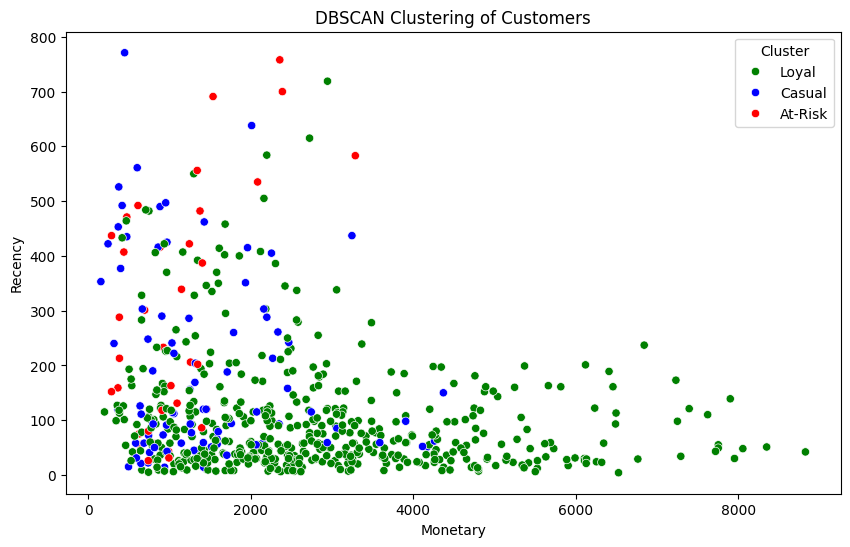

In [43]:
from sklearn.cluster import DBSCAN
# Áp dụng DBSCAN
dbscan = DBSCAN(eps=0.43, min_samples=4)
clusters = dbscan.fit_predict(customers_transformed_df)

# Thêm nhãn cụm vào DataFrame gốc
customers['Cluster'] = clusters

# Đánh giá kết quả phân cụm và đặt tên cho phân khúc khách hàng
cluster_mapping = {0: 'Loyal', 1: 'Casual', 2: 'At-Risk'}
customers['Cluster'] = customers['Cluster'].map(cluster_mapping)

# Định nghĩa bảng màu cho mỗi nhóm phân cụm
cluster_palette = {'Loyal': 'green', 'Casual': 'blue', 'At-Risk': 'red'}

# Hiển thị kết quả với bảng màu đã được điều chỉnh
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customers, x='Monetary', y='Recency', hue='Cluster', palette=cluster_palette, legend='full')
plt.title('DBSCAN Clustering of Customers')
plt.xlabel('Monetary')
plt.ylabel('Recency')
plt.show()



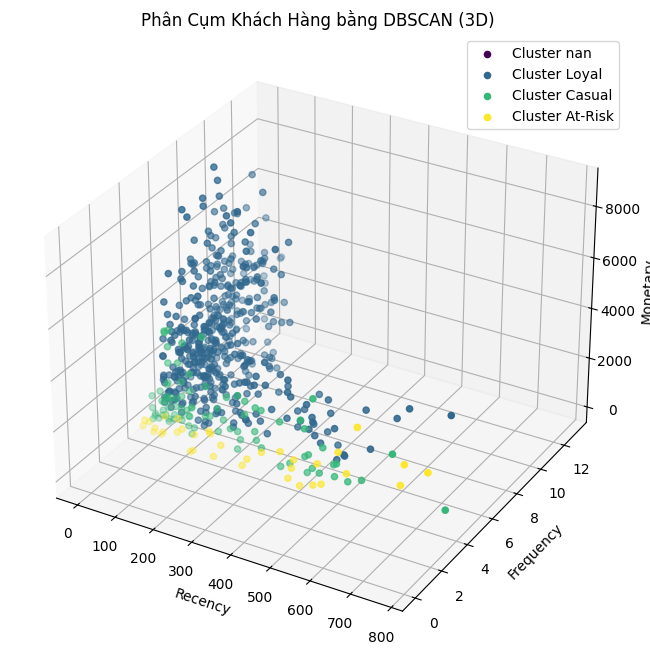

             Recency  Frequency  Monetary  Cluster
Customer ID                                       
AA-10315         185          5  5563.560      NaN
AA-10375          20          9  1056.390    Loyal
AA-10480         260          4  1790.512   Casual
AA-10645          56          6  5086.935    Loyal
AB-10015         416          3   886.156  At-Risk
...              ...        ...       ...      ...
XP-21865          44         11  2374.658    Loyal
YC-21895           5          5  5454.350      NaN
YS-21880          10          8  6720.444      NaN
ZC-21910          55         13  8025.707      NaN
ZD-21925         203          5  1493.944    Loyal

[793 rows x 4 columns]


In [44]:

import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Tạo biểu đồ 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Tạo màu cho từng cụm
unique_clusters = customers['Cluster'].unique()  # Lấy danh sách các nhóm phân cụm duy nhất
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))  # Tạo màu từ một màu sắc tuyến tính

# Vòng lặp để vẽ các điểm dữ liệu của từng nhóm phân cụm
for cluster, color in zip(unique_clusters, colors):
    cluster_data = customers[customers['Cluster'] == cluster]  # Lọc dữ liệu của từng nhóm phân cụm
    # Vẽ các điểm dữ liệu trên biểu đồ 3D, sử dụng các thuộc tính Recency, Frequency và Monetary
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], c=[color], label=f'Cluster {cluster}')

# Đặt tiêu đề và các nhãn trục cho biểu đồ 3D
ax.set_title('Phân Cụm Khách Hàng bằng DBSCAN (3D)')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.legend()  # Hiển thị chú thích về các nhóm phân cụm
plt.show()  # Hiển thị biểu đồ

# In ra kết quả của phân cụm
print(customers)



In [45]:
import pandas as pd
import numpy as np
import plotly.express as px

# Giả sử bạn có DataFrame 'customers' với các cột 'Recency', 'Frequency', 'Monetary' và 'Cluster'

# Tạo màu cho từng cụm
unique_clusters = customers['Cluster'].unique()
colors = px.colors.qualitative.Plotly[:len(unique_clusters)]

# Tạo dictionary mapping từ cụm sang màu
color_mapping = {cluster: color for cluster, color in zip(unique_clusters, colors)}

# Áp dụng mapping màu cho từng cụm trong DataFrame
customers['Color'] = customers['Cluster'].map(color_mapping)

# Tạo biểu đồ 3D với Plotly
fig = px.scatter_3d(
    customers,
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Cluster',
    title='Phân Cụm Khách Hàng bằng DBSCAN (3D)',
    color_discrete_map=color_mapping
)
#tăng kích thươsc cho biểu đồ
fig.update_layout(
    width=1200,  # Chiều rộng của biểu đồ
    height=900   # Chiều cao của biểu đồ
) 
# Hiển thị biểu đồ
fig.show()


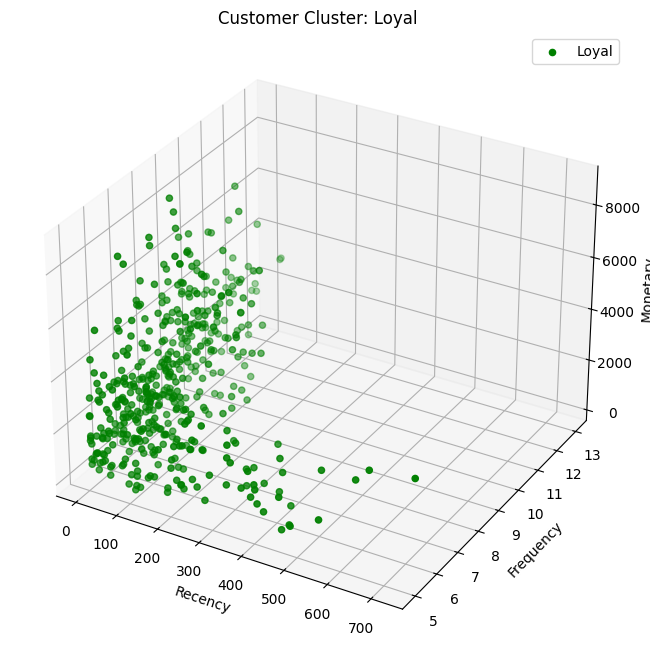

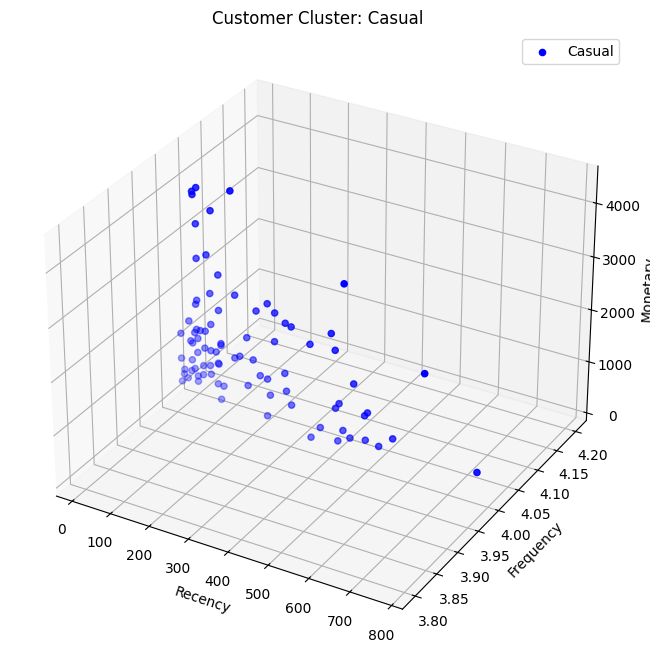

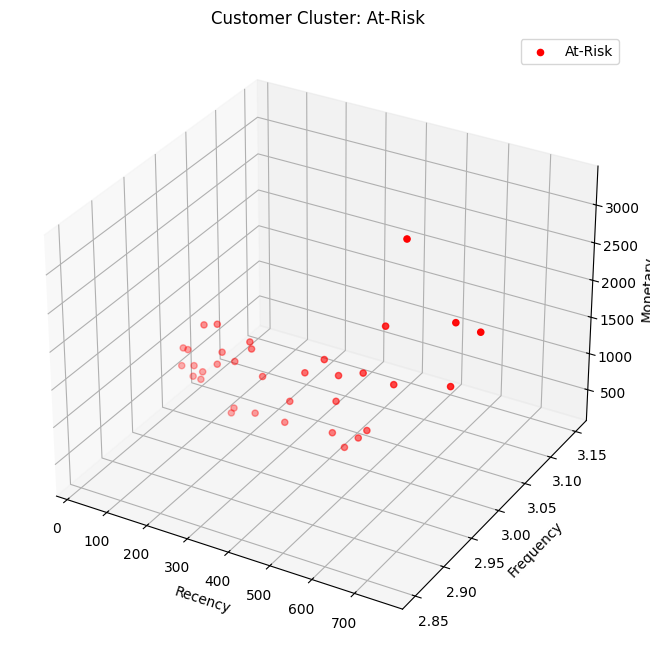

In [46]:
# Tạo danh sách màu cho mỗi nhóm phân khúc
cluster_colors = {'Loyal': 'green', 'Casual': 'blue', 'At-Risk': 'red'}

# Lặp qua từng nhóm và vẽ biểu đồ cho mỗi nhóm
for cluster, color in cluster_colors.items():
    # Lấy dữ liệu cho nhóm hiện tại
    cluster_data = customers[customers['Cluster'] == cluster]
    
    # Vẽ biểu đồ 3D cho từng nhóm
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], c=color, label=cluster)
    ax.set_title(f'Customer Cluster: {cluster}')
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    ax.legend()
    plt.show()



# Ý nghĩa
Bằng cách phân cụm khách hàng dựa trên hành vi mua hàng, bao gồm ba tiêu chí: Recency (Thời gian gần nhất mua hàng), Frequency (Tần suất mua hàng), Monetary (Giá trị tiền mỗi lần mua hàng), đã phân khúc khách hàng thành ba thành cụm chính 'Loyal' (Khách hàng trung thành) là Những khách hàng này không chỉ mua sắm thường xuyên mà còn chi tiêu nhiều và thường quay lại mua hàng trong khoảng thời gian gần đây.  'Casual' (Khách hàng không thường xuyên) là Những khách hàng này mua hàng không quá thường xuyên và không chi tiêu nhiều như khách hàng trung thành. 'At-Risk' (Khách hàng có rủi ro) là Những khách hàng này đã không mua hàng trong một thời gian dài, ít khi mua hàng và chi tiêu ít. Thông qua phương pháp phân cụm dựa trên mật độ DBSCAN (Density-Based Spatial Clustering of Applications with Noise) có thể giúp phát hiện các nhóm khách hàng có đặc điểm tương tự nhau một cách chi tiết. Từ đó đưa ra chiến lược kinh doanh cụ thể: 
- a. Khách hàng trung thành (Loyal Customers)
- - Đặc điểm: Có giá trị Recency, Frequency và Monetary cao.
- -  Biện pháp giữ chân:
Ưu đãi độc quyền: Cung cấp các ưu đãi chỉ dành riêng cho nhóm này như giảm giá đặc biệt, chương trình tích điểm đổi quà.
Gửi email cảm ơn: Tạo cảm giác được quan tâm và đánh giá cao bằng cách gửi email cảm ơn sau mỗi giao dịch.
Voucher chất lượng và quà tặng tri ân: Gửi tặng các voucher giá trị hoặc quà tặng để tri ân sự trung thành của họ.
- b. Khách hàng bình thường (Regular Customers)
- - Đặc điểm: Có giá trị Frequency và Monetary trung bình, Recency trung bình hoặc cao.
- - Biện pháp thu hút:
Chương trình khuyến mãi đặc biệt: Tổ chức các chương trình khuyến mãi hấp dẫn để kích thích họ mua sắm nhiều hơn.
Tăng cường tương tác: Gửi thông tin về sản phẩm mới, ưu đãi đặc biệt qua email hoặc SMS để duy trì sự quan tâm của họ.
Chương trình khách hàng thân thiết: Tạo chương trình tích điểm hoặc nhận thưởng khi mua hàng nhiều hơn để tăng tần suất mua hàng.
- c. Khách hàng rủi ro (At-Risk Customers)
- - Đặc điểm: Có giá trị Recency thấp, Frequency và Monetary có thể cao hoặc trung bình.
- - Biện pháp kích thích:
Gửi email nhắc nhở: Gửi email nhắc nhở về các sản phẩm yêu thích hoặc khuyến mãi để thu hút họ quay lại mua hàng.
Khuyến mãi đặc biệt để quay lại: Cung cấp các khuyến mãi đặc biệt, giảm giá sâu để thu hút họ quay lại.
Khảo sát ý kiến: Gửi khảo sát để hiểu lý do họ không quay lại mua hàng, từ đó cải thiện dịch vụ và sản phẩm.

Qua đó không chỉ giúp hiểu rõ hơn về khách hàng mà còn hỗ trợ trong việc xây dựng các chiến lược tiếp thị và chăm sóc khách hàng phù hợp, từ đó tối ưu hóa doanh thu và sự hài lòng của khách hàng. Việc áp dụng các biện pháp chiến lược phù hợp cho từng nhóm khách hàng sẽ giúp doanh nghiệp duy trì và phát triển mối quan hệ bền vững với khách hàng, tăng cường lòng trung thành và tối đa hóa giá trị lâu dài.
